1. Camera Calibration
=======================

In [1]:
import matplotlib
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import pickle
import os
import re

In [2]:
class CalibrateCamera():
    """ Initialize - either go through and calculate the camera calibration if 
        no pickle file exists. If the pickle file exists, just load the file.
    """

    def __init__(self, calibration_dir='../camera_cal', pickle_file='calibrationdata.p'):
        """ Initialize CalibrateCamera"""
        self.mtx = None
        self.dist = None
        self.img_size = None

        if not os.path.isfile(pickle_file):

            # Mapping each calibration image to a number of checkboard corners
            objp_dict = {
                1: (9, 5),
                2: (9, 6),
                3: (9, 6),
                4: (9, 6),
                5: (9, 6),
                6: (9, 6),
                7: (9, 6),
                8: (9, 6),
                9: (9, 6),
                10: (9, 6),
                11: (9, 6),
                12: (9, 6),
                13: (9, 6),
                14: (9, 6),
                15: (9, 6),
                16: (9, 6),
                17: (9, 6),
                18: (9, 6),
                19: (9, 6),
                20: (9, 6),
            }
            # Arrays to store object points and image points from all
            # the images
            objpoints = []  # 3D points in real world space
            imgpoints = []  # 2D points in image plane

            # Go through all images and find corners
            for k in objp_dict:
                nx, ny = objp_dict[k]

                # Prepare object points, like (0, 0, 0), (1, 0, 0) ...
                objp = np.zeros((nx * ny, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

                # Termination criteria
                criteria = (cv2.TERM_CRITERIA_EPS +
                            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

                # Make a list of calibration images
                fname = calibration_dir+'/calibration{}.jpg'.format(str(k))
                image = cv2.imread(fname)
                img = np.copy(image)
                self.img_size = (img.shape[1], img.shape[0])

                # Convert to grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Find the chessboard corners
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

                # If found, add object points, image points (after refining
                # them)
                if ret == True:
                    objpoints.append(objp)
                    cv2.cornerSubPix(gray, corners, (11, 11),
                                     (-1, -1), criteria)
                    imgpoints.append(corners)

                    # Draw and display the corners
                    img = cv2.drawChessboardCorners(
                        img, (nx, ny), corners, ret)
                    # plt.imshow(img)
                    cv2.imwrite(
                        '../output_images/calibrated{}.png'.format(str(k)), img)
                else:
                    print('Warning: ret = {} for {}'.format(ret, fname))

                # Calibrate camera and distort
                ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(
                    objpoints, imgpoints, self.img_size, None, None)

            # done and found all chessboard corners.
            # Save results into a pickle file for later retrieval

            try:
                with open(pickle_file, 'w+b') as f:
                    print('Saving data to pickle file :{}....'.format(pickle_file))
                    save_dict = {'img_size': self.img_size,
                                 'mtx': self.mtx,
                                 'dist': self.dist}
                    pickle.dump(save_dict, f, pickle.HIGHEST_PROTOCOL)
                    print('Camera Calibration Data saved to', pickle_file)

            except Exception as e:
                print('Unbale to save data to ', pickle_file, ':', e)
                raise

        # If previously saved pickle file of the distortion correction has been found
        # Retrieve it
        else:
            try:
                with open(pickle_file, 'rb') as f:
                    pickle_data = pickle.load(f)
                    self.img_size = pickle_data['img_size']
                    self.mtx = pickle_data['mtx']
                    self.dist = pickle_data['dist']
                    del pickle_data
                    print('Camera Calibration data restored from', pickle_file)

            except Exception as e:
                print('Unable to restore camera calibration data from',
                      pickle_file, ':', e)
                raise

    # Get the camera calibration result that the rest of the pipeline
    def get(self):
        """ Function that returns the camera calibration parameters"""
        return self.mtx, self.dist, self.img_size


In [4]:
# Global variables
with open('camera_cal/calibrationdata.p', 'rb') as f:
    save_dict = pickle.load(f)
    
mtx = save_dict['mtx']
dist = save_dict['dist']


2. Distortion correction
===========================

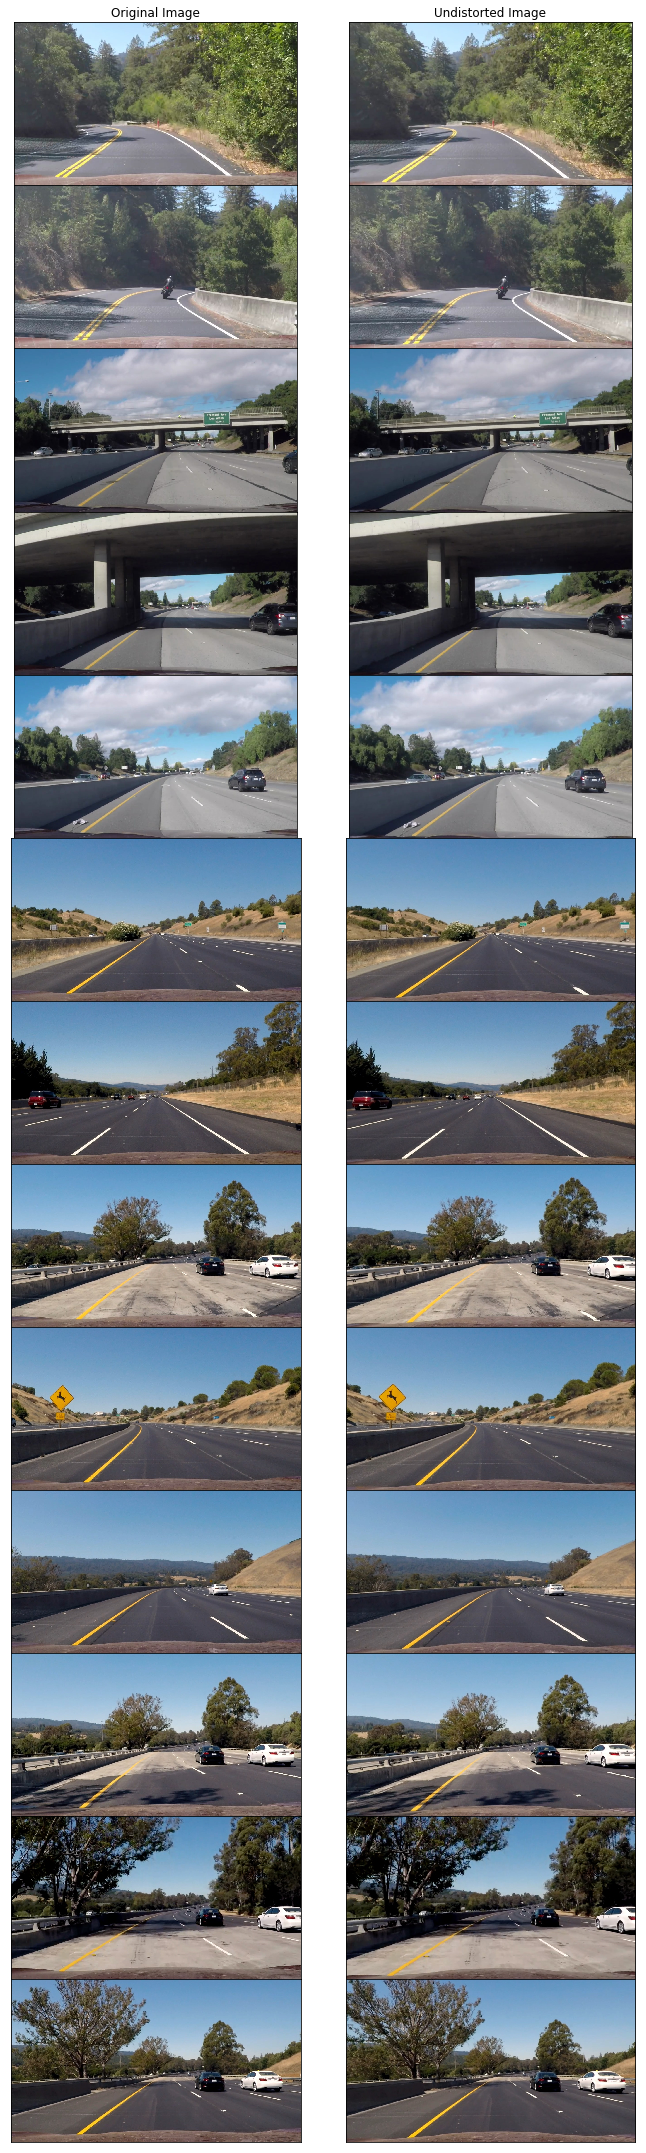

In [17]:
import matplotlib.gridspec as gridspec
def process_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# Make a list of test images
filepath = "test_images/"
images = glob.glob(filepath+'*.jpg')

# Setup plot
fig = plt.figure(figsize=(12, len(images)*3))
w_ratios = [1 for n in range(2)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 2, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# loop through and display test images and undististort them
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])
        
    # process image
    img2 = process_image(img)
        
    # next image
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(img)
    if i==0:
        ax.set_title('Original Image')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    i += 1
    ax = plt.Subplot(fig, grid[i])
    ax.imshow(img2)
    if i==1:
        ax.set_title('Undistorted Image')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    i += 1
        
plt.show()

3. Color and Gradient Thresholding
=====================

In [18]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    thresh_min,thresh_max = thresh[0],thresh[1]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.absolute(np.arctan2(abs_sobely, abs_sobelx))
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

def hls_thresh(img, thresh=(100, 255)):
    # convert RGB to HLS and threshold to binary image using
    # S channel
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def pipeline(img, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50,100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50,100 ))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 205))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_thresh(image, thresh=(170, 255))
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary == 1)] = 1
    
    return gradx, grady, mag_binary, dir_binary, hls_binary, combined



    

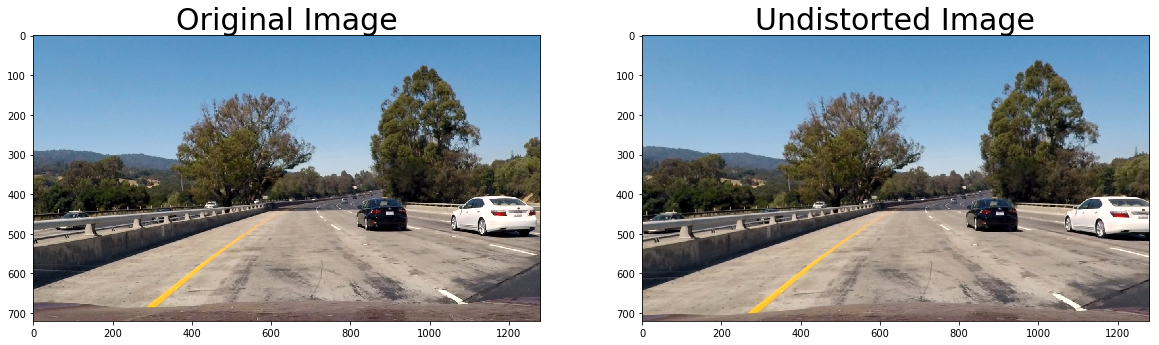

In [31]:
# Read in an image
#image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test1.jpg') 
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements


image_undistort = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [32]:
gradx, grady, mag_binary, dir_binary, hls_binary, combined = pipeline(image_undistort, ksize)

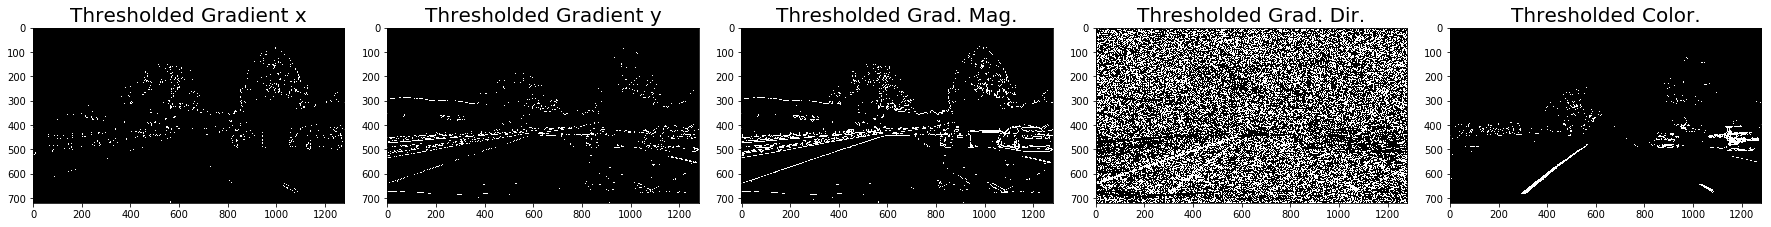

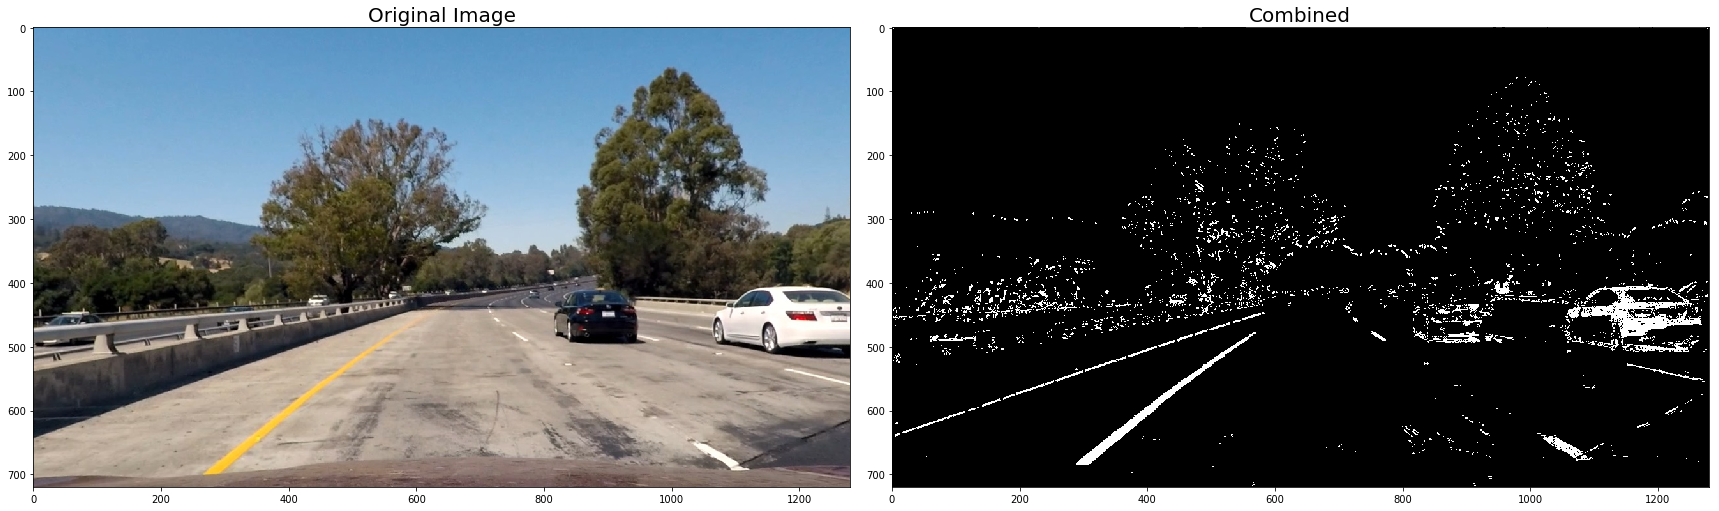

In [33]:

# Plot the results
fontsize=20
f, (ax1, ax2,ax3,ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Thresholded Gradient x', fontsize=fontsize)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Thresholded Gradient y', fontsize=fontsize)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Thresholded Grad. Mag.', fontsize=fontsize)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Thresholded Grad. Dir.', fontsize=fontsize)
ax5.imshow(hls_binary, cmap='gray')
ax5.set_title('Thresholded Color.', fontsize=fontsize)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_undistort)
ax1.set_title('Original Image', fontsize=fontsize)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=fontsize)

The code that is used to perform Perspective Transfrom is found in ```ProjectionManager.py``` file from line ```285 to 297```

```python
    # function to project the undistorted camera image to a plane looking down.
    def unwarp_lane(self, img, src, dst, mtx):
        # Pass in your image, 4 source points src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a top-down view
        M = cv2.getPerspectiveTransform(src, dst)
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        # warped = gray
        return warped, M
```

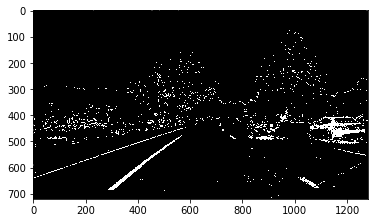

In [35]:
img = np.copy(combined)
plt.imshow(img, cmap='gray')

In [36]:
warped, unwarped, m, m_inv = perspective_transform(img)

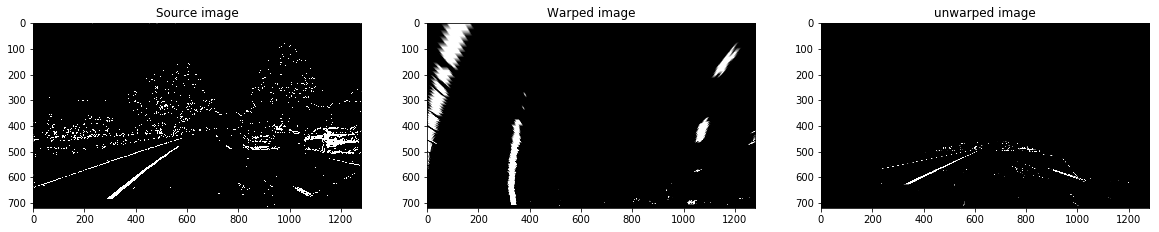

In [37]:
# Visualize Perspective transform 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.set_title('Source image')
ax1.imshow(img, cmap='gray')

ax2.set_title('Warped image')
ax2.imshow(warped, cmap='gray')

ax3.set_title('unwarped image')
ax3.imshow(unwarped, cmap='gray')

plt.show()

## Lane fit Video

## Full Color and Gradient Thresholding and Perspective Transform Pipeline in action
![](output_images/test1diag1.jpg)

![](output_images/test1diag2.jpg)

![](output_images/test1diag3.jpg)



## 1 Software Architecture
Our pipeline implementation is made up of 7 major components, and we will go into them in detail in section 1.2. 
#### 1.1 Design Goals
The software must meet the following design goals to be successful:

1. Apply a distortion correction to the raw image
2. Use color transforms, gradients, etc., to create a threshold binary image
3. Apply a perspective transform to rectify binary image ("birds-eye view")
4. Detect lane pixels and fit to find lane boundaries
5. Determine curvature of the lane and vehicle position with respect to center
6. Warp the detected lane boundaries back onto the original image
7. Output visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position.



#### 1.2 Components and Modulization

To achieve the design goals, we will create a pipeline made of 7 components.  Each of these are described here briefly.

1. **CameraCal:** Python class that handles camera calibrations operations
2. **ImageFilters:** Python class that handles image analysis and filtering operations
3. **ProjectionManager:** Python class that handles projection calculations and operations
4. **Line:** Python class that handles line detection, measurements and confidence calculations and operations.  There are two instances of this class: LeftLane and RightLane.
5. **RoadManager:** Python class that handles image, projection and line propagation pipeline decisions
6. **DiagManager:** Python class that handles diagnostic output requests
7. **P4pipeline.py:** Main Python CLI component that handles input/output filename checking, option selections and media IO.

This is a block diagram of how the classes are organized to process an image or a video (sequence of images):

![P4pipeline Block Diagram](./images/P4pipelineStructure.png)

*NOTE: This project started out as a Jupyter Notebook, but was abandoned because of versioning issues, and was getting too large.  However, we will use the graphics produced by the last version of the Notebook in this document.  An HTML version of the notebook can be accessed [here](./P4.html).*

## 2 Software Pipeline
### 2.1 Usage and Operations
The P4pipeline.py CLI can be executed in the command line using the following method.  For infilename, it will accept JPEG and PNG image files, or MPEG4 video files.  Output file extension should match the input as to type of file (single image versus video.)

```
usage: python P4pipeline.py [options] infilename outfilename

DIYJAC's Udacity SDC Project 4: Advanced Lane Finding Pipeline

positional arguments:
  infilename   input image or video file to process
  outfilename  output image or video file

optional arguments:
  -h, --help   show this help message and exit
  --diag DIAG  display diagnostics: [0=off], 1=filter, 2=proj 3=full
  --notext     do not render text overlay
```

*NOTE: P4pipeline.py is implemented with fail-safe, so if your specified output file is detected to exists, the pipeline will refuse to run and overwrite it.  If this situation occurs, either specify another output filename, or delete the original output file before trying again.*

## 3 Implementation Details
The following sections describe the implementation of the pipeline in detail and why this particular implementation was chosen.  Some factors of the architecture decision was based on efficiency, or observed improvements with video processing that were not observed when processing single images.  Where such observations were made, the subsequent improvements mostly improved both single image and video processing.  Cases where the improvements made single image processing suffer, we decide to make the change anyway, since we are bias toward making the lane boundaries identification video processing better.

### 3.1 Camera Calibration


![Camera Calibration Chessboards](./output_images/chessboardresults.png)

Once we are done with camera calibrations, we can save the results of the distortion correction matrix generated by the OpenCV *calibrateCamera* function into a pickle file for later usage without having to regenerate them again and again.  The generation, saving to pickle and later retrievals are all handled by the **CameraCal** module mentioned earlier, and you may view it [here](./p4lib/cameraCal.py).
### 3.2 Pipeline (Single Images)
After generating the camera undistortion matrix, we can now start using test images to practice finding lane lines using our software pipeline as we are in development.
#### 3.2.1 Test Images
We were given a set of eight test images to start with.  However, not being statisfied with just the eight, we added an additional fifteen images from the project, challenge and harder challenge videos to bring the total number of test images to twenty-three.  They are shown in the next session where we undistort them like the camera calibration chessboard images.
#### 3.2.2 Distortion Correction
The first thing the P4pipeline does when it starts its pipeline modules is to use the **ImageFilters** module to correct the distortion in the image using the generated distortion correction matrix obtained by the **CameraCal** module using camera calibration techniques as discussed in section 3.1.  Below, the twenty-three raw/unprocessed test images are shown on the left and the results of the distortion correction is shown on the right.  They may look very similar until you look at their edges.  The distortion corrected images have a smaller field of view than the uncorrected image.

![Undistorted Test Images](./output_images/undistortresults.png)

#### 3.2.3 Image Filters
Next the **ImageFilters** module will apply filters to the images in an attempt to isolate the pixels that makes the lane lines.  In each of the subsections, we will describe a filter deployed by the **ImageFilters** module either in sequence or in combination.  You may view the **ImageFilters** module [here](./p4lib/imageFilters.py).

##### 3.2.3.1 RGB Colorspace Thresholding

One of the most difficult lane lines to isolate are the yellow lane lines.  Since they use only two of the three RGB (Red, Green, Blue) color components, Red and Green, we can just use brightness (Luma) to detect them like white lines.  This become perticularly difficult when we encounter yellow lane lines in images with poor visibility:

![Yellow Lane Lines in poor visibility image](./test_images/test15.jpg)

###### 3.2.3.1.1 Red

Using thresholding on the red color channel in an RGB colorspace, we can render this image from the poor visibility image:

![Yellow Lane Lines enhanced using Red color channel thresholding](./output_images/test15diag1-redfilter.png)

How we do it is we apply the following to a RGB image with pixels in unsigned 8-bit integer:

```
        rEdgeDetect = img[:,:,0]/4
        rEdgeDetect = 255-rEdgeDetect
        rEdgeDetect[(rEdgeDetect>220)] = 0
```

What this filter does is that it compresses the red color channel space to 1/4 its normal value, then it inverts it so that its lowest value now becomes its highest.  Then a threshold is selected to drop any value higher than it to be 0, in this example the value 220 was selected as the threshold.  (Remember, since we divided by 4, our range became (255-63 to 255), or (192 to 255.)  What we are left with is a set of pixels that at higher than normal intensity compressed and then forced into a higher set of values within the red color channel.
However, this filter does not work for all cases, and become perticularly difficult when we encounter yellow lane lines drawn on nearly white concrete backgrounds as shown here:

![Yellow Lane Lines on Concrete Bridge](./test_images/test1.jpg)

![ImageFilters applied on test1](./output_images/test1diag1-redfilter.png)

So, we need to continue searching for additional image filters.

##### 3.2.3.2 Sobel Thresholding

The Sobel operators combine the idea of Gaussian smoothing and differentiation filters and is at the heart of Canny edge detection algorithm.  Since the filter takes the first, second, third, or mixed image derivatives of the grayscaled image, the result is more or less resistant to any noise in the image and reliable edges are produced.  More about the OpenCV libraries implementation of the Sobel operator is available [here](http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#sobel).

###### 3.2.3.2.1 Sobel X and Y Derivitives

The Sobel image derivitives in the X direction is given by the following formula assuming a 3x3 kernel.  

![Sobel Operator derivitive in the X direction](http://docs.opencv.org/2.4/_images/math/f2531c53069c2dabcab2bcb391518bd65dc535eb.png)

The Sobel image derivitives in the Y direction is given by the following formula assuming a 3x3 kernel.

![Sobel Operator derivitive in the X direction](http://docs.opencv.org/2.4/_images/math/03e50d0ac972c69085ccbff5cadd0b53f791fce8.png)

Kernels must be 1, 3, 5, or 7.  Kernels of larger size will provide a softer smoother gradient image.  For our purpose, we need sharp edges, so a kernel of 3 was defaulted.  Once we have the results, we need to take the absolute value of the derivative or gradient and scale them back to 8-bit unsigned integers, since we will be, in essence, using it as a bitmap to isolate the lane lines.  The **ImageFilters** module uses the following code to create the filter:

```
    # Define a function that applies Sobel x or y,
    # then takes an absolute value and applies a threshold.
    def abs_sobel_thresh(self, img, orient='x', thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        # 3) Take the absolute value of the derivative or gradient
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        # 5) Create a mask of 1's where the scaled gradient magnitude
        #    is > thresh_min and < thresh_max
        # 6) Return this mask as your binary_output image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
            abs_sobel = np.absolute(sobelx)
        if orient == 'y':
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
            abs_sobel = np.absolute(sobely)
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        ret, binary_output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
        # Return the result
        return binary_output
```

Later on, we will discuss how the **ImageFilters** module will filter the images differently based on the images' statistics that we will explain in section 3.2.3.5, Image Analysis.  But for now, for test2 image, as an example of how this filter works:

![Test2 image](./test_images/test2.jpg)

We applied a threshold of (25,50) for Sobel in the X direction and (50, 150) for Sobel in the Y direction to get this image where Sobel X is in the red color channel and Sobel Y is in the blue color channel:

![Test2 Sobel X and Y Applied](./output_images/test2diag1-sobelxy.png)

Again this is still not enough, because we still get nasty results of missing yellow lane line from that test1 image using this filter:

![Test1 Sobel X and Y Applied](./output_images/test1diag1-sobelxy.png)

###### 3.2.3.2.2 Sobel Magnitude and Directional
The idea of taking the magnitude (Sobel XY) of the Sobel X and Y results is to see if there is a distance factor in the individual components in the gradient that can be used to further isolate the lines/edges in the image.  Sobel XY is calculated by squaring the X and Y components of the Sobel operator and then take the square root of their sum, and, in essence, calculate the magnitude of changes in intensity that being experienced by that pixel in that image.  If there is an absence of any one of the components for a particular pixel, then the value produced at that pixel is just the same as for the Sobel X or Y component remaining.  The formula is:

![Sobel Magnitude Formula](./images/sobel-mag-formula.png)

The **ImageFilters** module uses the following function to create the filter:
```
    # Define a function that applies Sobel x and y,
    # then computes the magnitude of the gradient
    # and applies a threshold
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # 6) Create a binary mask where mag thresholds are met
        ret, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
        # 7) Return this mask as your binary_output image
        return mag_binary
```

The idea of taking the directional Sobel is a to try to isolate edges based on an orientation.  It is simply the arctangent of the y-gradient divided by the x-gradient.  The formula is:

![Sobel Directional Formula](./images/sobel-dir-formula.png)

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines.
The **ImageFilters** module uses the following function to create the filter:

```
    # Define a function that applies Sobel x and y,
    # then computes the direction of the gradient
    # and applies a threshold.
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the direction of the gradient
        # 4) Take the absolute value
        with np.errstate(divide='ignore', invalid='ignore'):
            dirout = np.absolute(np.arctan(sobely/sobelx))
            # 5) Create a binary mask where direction thresholds are met
            dir_binary =  np.zeros_like(dirout).astype(np.float32)
            dir_binary[(dirout > thresh[0]) & (dirout < thresh[1])] = 1
            # 6) Return this mask as your binary_output image
        # update nan to number
        np.nan_to_num(dir_binary)
        # make it fit
        dir_binary[(dir_binary>0)|(dir_binary<0)] = 128
        return dir_binary.astype(np.uint8)
```

Again, later on, we will discuss how the **ImageFilters** module will filter the images differently based on the images' statistics that we will explain in section 3.2.3.5, Image Analysis.  But for now, for test2 image, as an example of how this filter works:

![Test2 image](./test_images/test2.jpg)

We applied a threshold of (50, 250) for Sobel XY (Magnitude) and (0.7, 1.3) for Sobel directional (we are looking for verticle lines) to get this image where Sobel XY is in the green color channel and Sobel Directional is in the blue color channel:

![Test2 Sobel X and Y Applied](./output_images/test2diag1-sobelmagdir.png)

Again this is still not enough, because we still get nasty results of missing yellow lane line from that test1 image using this filter:

![Test1 Sobel X and Y Applied](./output_images/test1diag1-sobelmagdir.png)

##### 3.2.3.3 HLS Colorspace Thresholding

Obviously by now, we know that Sobel operations, in all of its wonderful various forms, will not fulfill our yellow lane line finding needs.  Its now time to look at other colorspaces for inspirations.  This time we will look at HLS (**Hue**, **Lightness** and **Saturation**).  **Hue** represents color independent of any change in brightness.  **Lightness** represents luminacity or brightness, and can be compared to converting an RGB image to grayscale.  **Saturation** is a measurement of colorfulness as compared to *whiteness*.  The HLS (hue, lightness, saturation) color space is a cylindrical representation of the RGB model. **Hue** is measured in degrees around the circumference of the cylinder. *Red* is at 0°, *green* at 120°, and *blue* at 240°, then wrapping back to *red* at 360°. Note that there is a discontinuity at 0° and 360°. **Saturation** is measured in percent from the center of the cylinder to its radius. Lightness is measured in percent from the bottom to the top of the cylinder.  You can find more information about colorspaces [here](https://www.codeproject.com/articles/243610/the-known-colors-palette-tool-revised-again) and [here](https://www.script-tutorials.com/what-is-a-color-model/)

![Hue Lightness Saturation Color Space Model](https://www.codeproject.com/KB/miscctrl/RevisedKnownColorsPalette/HSL_color_cylinder.png)

For our lane finding needs, we will drop the **Lightness** color channel as a means of filtering and look at **Hue** and **Saturation** color channels to threshold instead.  We are interested in filtering for the yellow lane lines against white background since the Sobel functions are excellent in filtering for edge detection based on luminance already.  The **Hue** color channel is an obvious candidate for filter yellow lane lines, and **Saturation** (value of color away from white) will help too.
The **ImageFilters** module uses the following function and OpenCV *cvtColor* function to create these two filters:

```
    # Define a function that thresholds the S-channel of HLS
    def hls_s(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s = hls[:,:,2]
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        return s_binary

    # Define a function that thresholds the H-channel of HLS
    def hls_h(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h = hls[:,:,0]
        retval, h_binary = cv2.threshold(h.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        return h_binary
```

Again, later on, we will discuss how the **ImageFilters** module will filter the images differently based on the images' statistics that we will explain in section 3.2.3.5, Image Analysis.  But for now, for test2 image, as an example of how this filter works:

![Test2 image](./test_images/test2.jpg)

We applied a threshold of (50, 100) for **Hue** and (88, 190) for **Saturation** to get this image where **Hue** is in the blue color channel and **Saturation** is in the red color channel:

![Test2 Sobel X and Y Applied](./output_images/test2diag1-HS.png)

These two filters appears to be mutually exclusive.  The filter created by using thresholding against the **Hue** color channel can be used to mask out the white background.  The filter created by thresholding against the **Saturation** color channel can be used for finding the yellow lane lines.  In practice, this works quite well, even against test1 image's nasty yellow lane line against its white concrete bridge background using this filter:

![Test1 Sobel X and Y Applied](./output_images/test1diag1-HS.png)

Success at Last!

##### 3.2.3.4 Filter Combinations
As can be seen from the previous set of filters, not a single one of them can produce the lane line isolation that we would like to achieve.  However, in combination, they very well may!  Below was the first iteration of the filter combination we attempted for the Project video.  The **ImageFilters** module uses this combination at the beginning:

```
combined[((gradx > 0) | (grady > 0) | ((magch > 0) & (dirch > 0)) | (sch > 0)) & (shadow == 0) & (rEdgeDetect>0)] = 35
```

And this combination produced the following combination at the end as indicated by the **Final Mask Combination** column.

![Image Filters](./output_images/imagefiltersresults.png)

The resulting threshold binary image worked well in the video mostly, but was brittle.  There were still many places it would fail.  If there were only a way we could apply multiple combinations of thresholds to what the images needed for finding lane lines.  As it turned out, there was!  In comes image analysis.

##### 3.2.3.5 Image Analysis

What is at issue is that we were applying the same thresholds on different images with different lighting conditions.  As with previous Machine Learning techniques, we learned that normalization of the data were essential for being able to retrieve useful information.  This is no exception.  The idea is that based on statistics of the images we have, we should be able to figure out what is the optimum filter combination for each type of image, so that we don't have to treat them all the same.  So, first we have to generate a set of useful information on the images as a base to try to figure out how to generate more tailored filter combinations.  Below are the results of this study.  The **ImageFilters** module uses the *imageQ* function to generate the statics:

![Image Analysis](./output_images/imageanalysisresults.png)

But now that we have the statistics, how about just correcting the image ourselves?  That is what we will try next!

##### 3.2.3.6 Exposure Correction/Normalization (Experimental)

Now that we have some statistics on the images, our reasoning is could we not just use some digital image techniques to rebalance the image?  We attempted to do this in **ImageFilters** module using its *balanceEx* function as shown below:

*NOTE: We could have tried the Gamma correction function in OpenCV, but wanted to experiment with different thresholding and masking techniques.*

```
    def balanceEx(self):
        # separate each of the RGB color channels
        r = self.curRoadRGB[:,:,0]
        g = self.curRoadRGB[:,:,1]
        b = self.curRoadRGB[:,:,2]
        # Get the Y channel (Luma) from the YUV color space
        # and make two copies
        yo = np.copy(self.curRoadL[:,:]).astype(np.float32)
        yc = np.copy(self.curRoadL[:,:]).astype(np.float32)
        # use the balance factor calculated previously to calculate the corrected Y
        yc = (yc/self.roadbalance)*8.0
        # make a copy and threshold it to maximum value 255.
        lymask = np.copy(yc)
        lymask[(lymask>255.0)] = 255.0
        # create another mask that attempts to masks yellow road markings.
        uymask = np.copy(yc)*0
        # subtract the thresholded mask from the corrected Y.
        # Now we just have peaks.
        yc -= lymask
        # If we are dealing with an over exposed image
        # cap its corrected Y to 242.
        if self.roadlrgb[0] > 160:
            yc[(b>254)&(g>254)&(r>254)] = 242.0
        # If we are dealing with a darker image
        # try to pickup faint blue and cap them to 242.
        elif self.roadlrgb[0] < 128:
            yc[(b>self.roadlrgb[3])&(yo>160+(self.roadbalance*20))] = 242.0
        else:
            yc[(b>self.roadlrgb[3])&(yo>210+(self.roadbalance*10))] = 242.0
        # attempt to mask yellow lane lines
        uymask[(b<self.roadlrgb[0])&(r>self.roadlrgb[0])&(g>self.roadlrgb[0])] = 242.0
        # combined the corrected road luma and the masked yellow
        yc = self.miximg(yc,uymask,1.0,1.0)
        # mix it back to the original luma.
        yc = self.miximg(yc,yo,1.0,0.8)
        # resize the image in an attempt to get the lane lines to the bottom.
        yc[int((self.y/72)*70):self.y,:] = 0
        self.yuv[self.mid:self.y,:,0] = yc.astype(np.uint8)
        self.yuv[(self.y-40):self.y,:,0] = yo[(self.mid-40):self.mid,:].astype(np.uint8)
        # convert back to RGB.
        self.curRoadRGB = cv2.cvtColor(self.yuv[self.mid:self.y,:,:], cv2.COLOR_YUV2RGB)
```

The resulting image is shown below.

*NOTE: Notice that the images are only corrected at the bottom half?  This is because we wanted to save on processing time and storage space.  Since we needed to find lane line boundaries, we just needed to correct the part of the image that contains them: the lower half!*

![Image Quality Enhancements](./output_images/imageenhancementresults.png)

##### 3.2.3.7 Filter Combination After Exposure Correction/Normalization (Experimental)

Once we had the new balanced lower half of the image where the lane lines were, we expected an easy win for just picking an optimal binary threshold combination.  This was not the case, as can be seen here.  While a lot of images now have lane lines that are easier to identify, it seems we still need multiple filter combinations.

![Enhanced Filter Combinations](./output_images/enhancedimagefiltersresults.png)

Although this is a feature worth further investigation, it is not an easy win, so we are placing it on hold.  Instead we will a set of Image filter combination for the rest of this project.
##### 3.2.3.8 Image Filter Set (Final Approach)
In the end, we decided to create five combinations.  One of them worked very well on the Project Video and another of the five worked very well on the Challenge Video.  The five combination's thresholds are described in the table below:

| Filter | Combination 1 | Combination 2 | Combination 3 | Combination 4 | Combination 5 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| Red | (> 210) | (> 210) | (>220) | (>220) | (>220) |
| Sobel X | (25, 100) | (25, 100) | (25, 100) | (30, 100) | (25, 100) |
| Sobel Y | (50, 150) | (50, 150) | (50, 150) | (75, 150) | (50, 150) |
| Sobel XY | (50, 250) | (50, 250) | (30, 150) | (30, 150) | (30, 150) |
| Sobel Dir | (0.7, 1.3) | (0.7, 1.3) | (0.6, 1.3) | (0.6, 1.3) | (0.5, 1.3) |
| Hue | (50, 100) | (50, 100) | (125, 175) | (125, 175) | (130, 175) |
| Saturation | (88, 190) | (88, 250) | (20, 100) | (20, 100) | (20, 80) |

Additional filter combinations may be defined later.  The **RoadManager** module currently uses the following logic to decide which filter combination to apply to the image.  We will discuss more about the **RoadManager** in sections 3.2.5, Lane Line Identification and 3.2.6, Lane Line Measurements.

```
        # detected cloudy condition!
        if self.curImgFtr.skyText == 'Sky Condition: cloudy' and self.curFrame == 0:
           self.cloudyMode = True

        # choose a default filter based on weather condition
        # NOTE: line class can update filter based on what it wants too
        # (different for each lane line).
        if self.cloudyMode:
            self.curImgFtr.applyFilter3()
            self.maskDelta = 20
            self.leftLane.setMaskDelta(self.maskDelta)
            self.rightLane.setMaskDelta(self.maskDelta)
        elif  self.curImgFtr.skyText == 'Sky Condition: clear' or \
              self.curImgFtr.skyText == 'Sky Condition: tree shaded':
            self.curImgFtr.applyFilter2()
        elif self.curFrame < 2:
            self.curImgFtr.applyFilter4()
        else:
            self.curImgFtr.applyFilter5()
```

And as explained earlier, we had some versioning issues with the Jupyter notebook and that was abandoned, but wanted to show what was working up to that point.  In the newer CLI implementation  of the software pipeline, you may generate a diagnostic screen of the image filters using the following syntax:

```
python P4pipeline.py --diag=1 <inputfile> <outputfile>
```

The following sample run:

```
python P4pipeline.py --diag=1 test_images/test1.jpg output_images/test1diag1.jpg
```

Produces this output:

![Test1 Diag 2 Output](./output_images/test1diag1.jpg)

##### 3.2.3.9 Horizon Line Detection

You may have noticed that there is a curious yellow line running across the right bottom panel of the test1diag1.jpg diagnostic screen, and ask what that is.  This is our attempt at detecting the road horizon in the image as part of the **ImageFilter** class.  It uses the **Sobel XY** (Magnitude) as a threshold for locating the horizon using this algorithm:

```
# function to detect the horizon using the Sobel magnitude operation
def horizonDetect(self, debug=False, thresh=50):
   	if not self.horizonFound:
       	img = np.copy(self.curRoadRGB).astype(np.uint8)
       	magch = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 150))
       	horizonLine = 50
       	while not self.horizonFound and horizonLine<int(self.y/2):
			magchlinesumd = np.sum(magch[horizonLine:(horizonLine+1),:]).astype(np.float32)
           	if magchlinesum > (self.x*thresh):
               	self.horizonFound = True
               	self.roadhorizon = horizonLine + int(self.y/2)
               	if debug:
                   	self.diag4[horizonLine:(horizonLine+1),:,0] = 255
                   	self.diag4[horizonLine:(horizonLine+1),:,1] = 255
                   	self.diag4[horizonLine:(horizonLine+1),:,2] = 0
           	else:
               	horizonLine += 1
```

But why should we care?  In the next stage of the pipeline, we will be performing a perspective to plane transform, and one of the issues with doing these types of transforms are its nonlinearity, particularly at the vanishing point, which is one of the points along the horizon of the perspective image.  As you approach the vanishing point, a short vertical distance in pixel space, represent a very large distance when projected in birds-eye view.  We will describe this in more details in *section 3.2.6, Lane Line Measurements.*

#### 3.2.4 Perspective to Plane Transform

One of the major difference between Project 1 and 4, is the requirement to apply a perspective transform to rectify the binary road image to a ("birds-eye view").  The reason to do this is to more easily identify the lane lines and to make curvature measurements.  We will use the **Pinhole Camera** mathematical model to transform the perspective view of the image plane into a planar 'birds-eye' view (view looking down from above).  See [here](https://en.wikipedia.org/wiki/Pinhole_camera_model) for the mathematics involved in doing projections in a **Pinhole Camera** model.

![Geometry of a pinhole camera](./images/pinhole_camera_model.png)

But in general, we are using the theoretical geometry of the pinhole camera model to project the (Y1, Y2) perspective image plane to a (x1, x2, x3) 3D space.  Then we will use just the (x1, x3) coordinates for the 'birds-eye' view mapping.  This equation gives how we derive at the (x1, x2, x3) coordinates giving (y1, y2) coordinates:

![Geometry calculations for 'birds-eye' view](https://wikimedia.org/api/rest_v1/media/math/render/svg/5f4b617d13f9fb4e5811f42de5437a2494f307c2)

Where f is the *focal length* of the pinhole camera.  But where do we find the *focal length*?  Recall we did the **Camera Calibration** in section 3.1?  Part of the calculation was also to derive the *camera focal lengths*.  See here for all of the mathematics involved in doing [Camera Calibration Calculations](http://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html) in OpenCV.  Once we have the *camera focal length*, we need to calculate the transform from the image plane to the 'birds-eye' view plane.  This involves calculating what is known as the [**Camera Matrix**](https://en.wikipedia.org/wiki/Camera_matrix).  This matrix is a 3x4 matrix which describes the mapping of a pinhole camera from 3D points in the world to 2D points in an image.

![Camera Matrix for calculating perspective transforms](https://wikimedia.org/api/rest_v1/media/math/render/svg/bcd081d35d8a12128c62d54b6c883afcf274f3e9)

We will be using OpenCV *getPerspectiveTransform* and *cv2.warpPerspective* functions to do the heavy lifting of deriving the **Camera Matrix** and performing the transformation from the perspective image plane to the 'birds-eye' view, but we still need to find four corners points on the road surface to project on to a planar "birds-eye view.  Project 1 back to the rescue with the Houghline function.  Recall we used the Houghline function to approximate the lane line locations.  Those identified lane lines are parallel in perspective, since they are suppose to form the lane lines which are also in parallel in perspective.  If we assume that the base of the lane lines, where the lane meets the bottom of the image, is also parallel to another line that is near the horizon, then we have a rectangle that are formed by the two sets of parallel lines (see the red lines in the left image below.)  We can use the corner points of this rectangle as our source points and then map them to a planar surface by warping their points as describe below using the orange and light blue dashed arrow lines.  The blue dashed line indicates that the image on both sides of the transform are symmetric and will remain symtric during the transformations. Therefore, we can repurpose so of the old codes from Project 1 to perform the initial task of not just estimate the lane lines, but to also calculate our source points.  It is important that we are able to calculate this dynamically because, we do not know in advance if the camera is facing a road going uphill or downhill and the perspective transform for them will be quite different and make it harder to identify lane lines.

![Perspective Image Transform](./images/projectiontransform.png)

We will be using our **ProjectionManager** module to handling these OpenCV *HoughLinesP* calculations and initial source point generation.  In general, we will be using the *HoughLinesP* function to find the left and right lane lines.  Using linear algebraic calculations, we will identify the Y intercept of both lines.  This, in theory, is where both the horizon is at and also the vanishing point in perspective.  From there, we will have to calculate a "backoff" from the horizon, since points near the vanishing point is theoretically at infinity and will not be useful.  Our current rule of thumb for a standard backoff during initialization is at 30 pixels; however, this is now no longer static and can be dynamically change during video processing based on detected horizon from the **ImageFilter** module which we will describe in section 3.2.6, Lane Line Measurements.  Below is the code segment that the **ProjectionManager** module uses to perform the backoff calculations:

```
    # find the right and left line's intercept,
    # which means solve the following two equations
    # rslope = ( yi - ry1 )/( xi - rx1)
    # lslope = ( yi = ly1 )/( xi - lx1)
    # solve for (xi, yi): the intercept of the left and right lines
    # which is:  xi = (ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope)
    # and        yi = ry2 + rslope*(xi-rx2)
    xi = int((ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope))
    yi = int(ry2 + rslope*(xi-rx2))

    # calculate backoff from intercept for right line
    if rslope > rightslopemin and rslope < rightslopemax:   # right
        ry1 = yi + int(backoff)
        rx1 = int(rx2-(ry2-ry1)/rslope)
        ry2 = ysize-1
        rx2 = int(rx1+(ry2-ry1)/rslope)
        cv2.line(img, (rx1, ry1), (rx2, ry2), [255, 0, 0], thickness)

    # calculate backoff from intercept for left line
    if lslope < leftslopemax and lslope > leftslopemin:   # left
        ly1 = yi + int(backoff)
        lx1 = int(lx2-(ly2-ly1)/lslope)
        ly2 = ysize-1
        lx2 = int(lx1+(ly2-ly1)/lslope)
        cv2.line(img, (lx1, ly1), (lx2, ly2), [255, 0, 0], thickness)

    # if we have all of the points - draw the backoff line near the horizon
    if lx1 > 0 and ly1 > 0 and rx1 > 0 and ry1 > 0:
        cv2.line(img, (lx1, ly1), (rx1, ry1), [255, 0, 0], thickness)

    # return the left and right line slope, found rectangler box shape and the estimated vanishing point.
    return lslope+rslope, lslope, rslope, (lx1,ly1), (rx1,ry1), (rx2, ry2), (lx2, ly2), (xi, yi)

```

We now have the calculated points: (lx1,ly1), (rx1,ry1), (rx2, ry2) and (lx2, ly2) that we can use as source point for the OpenCV *getPerspectiveTransform* function, but we still need a destination points for us to warp into.  Since our two stated goal outside of the project goals from the beginning is to:

1. Extend the rectified lane lines as far to the horizon as possible
2. Keep the correct aspect ratio when projecting the perspective view down to a planar ('birds-eye') view

It is reasonable that we will want to maintain symmetry as diagrammed earlier, so we came up with this code segment in the **ProjectionManager** module to help us map the resulting transform:

```
# normal image size
self.x, self.y = self.img_size

# generate destination rect for projection of road to flat plane
us_lane_width=12    # US highway width: 12 feet wide
approx_dest=20      # Approximate distance to vanishing point from end of rectangle
scale_factor=15     # scaling for display
top=approx_dest*scale_factor
left=-us_lane_width/2*scale_factor
right=us_lane_width/2*scale_factor
self.curDstRoadCorners = np.float32([[(self.x/2)+left,top],[(self.x/2)+right,top],[(self.x/2)+right,self.y],[(self.x/2)+left,self.y]])
```

Using these calculated source and destination rectangles, we are now able to perform the perspective transform in **ProjectManager** *unwarp_lane* function:

```
    # function to project the undistorted camera image to a plane looking down.
    def unwarp_lane(self, img, src, dst, mtx):
        # Pass in your image, 4 source points src = np.float32([[,],[,],[,],[,]])
        # and 4 destination points dst = np.float32([[,],[,],[,],[,]])
        # Note: you could pick any four of the detected corners
        # as long as those four corners define a rectangle
        # One especially smart way to do this would be to use four well-chosen
        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        # use cv2.warpPerspective() to warp your image to a top-down view
        M = cv2.getPerspectiveTransform(src, dst)
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        # warped = gray
        return warped, M
```

This function when applied to the test images, has the following outcome when using the last Jupyter notebook version:

*NOTE: We were not able to perform two of the perspective transform in the set of test images below.  This is because we were unable to find an estimated lane line in two of the video frames in the harder challenge video where the right lane line became obscured or nearly vertical.  These are just two of the many failure points in our current, even CLI, implementation.*

![Perspective Image Warped to Planar](./output_images/initialprojectionresults.png)

But as explained earlier, we had some versioning issues with the Jupyter notebook and that was abandoned, but wanted to show what was working up to that point.  In the newer CLI implementation  of the software pipeline, you may generate a diagnostic screen of the image perspective projection using the following syntax:

```
python P4pipeline.py --diag=2 <inputfile> <outputfile>
```

The following sample run:

```
python P4pipeline.py --diag=2 test_images/test5.jpg output_images/test5diag2.jpg
```

Produces this output:

![Test1 Diag 2 Output](./output_images/test5diag2.jpg)

To understand perspective images, you have to understand what is the **vanishing point**.  The **vanishing point** is formed by where the two estimated red lane lines meet with the yellow horizon line in the perspective image above in the upper-left panel.  It is important to realize that when we did the transform, we effectively stretched the pixels near the **vanishing point** to fit the top of our new planar 'birds-eye' view, while at the same time compressed the pixels near the bottom of our perspective image.  To understand this stretching effect better, we drew a dark green hexagon in the perspective image, and then projected it onto the planar 'birds-eye' view in the lower-left panel.  Notice how the bottom of the hexagon is now much smaller in the birds-eye view than in the perspective image?  What about the top of the hexagon?  The sides of the two longer sides of the hexagon are now parallel in the 'birds-eye' view.  What kind of stretching do you think are involved?  Also, notice how far to the top that the concrete bridge ends in the perspective image, but it seem quite short in comparison in the planar birds-eye view?  What's happening there?

![Perspective Image Transform](./images/projectiontransform.png)

This is all done inline to keep the birds-eye view aspect ratio correct as one of our stated goals.  This can be seen from the clearer more defined details of the concrete bridge as compared to the rest of birds-eye image.  It is important to keep in mind that the perspective transform is non-linear, especially near the **horizon** and particularly at the **vanishing point**.  What this means is that as you go closer and closer to the **horizon/vanishing point** in the perspective image, things are going farther and farther away.  This become quite non-intuitive in that what we assume is quite near, is often quite far away.  This particular article should shed some light on this subject: [Slow Down, Those lane lines are longer than you think!](http://researchnews.osu.edu/archive/seeline.htm)

Since we have compress the pixels at the bottom of the new birds-eye view image, it is reasonable to hypothesize that more accurate lane line information is there as well.  Especially since the source points for the transformation was the estimated lane lines themselves.  To indicate this, we drew two parallel red lines from the bottom of the birds-eye image to near where the backoff points should be.  Those two red parallel lines are, in essence, the initial lane line estimates, so we will start from there in the next section.

#### 3.2.5 Lane Line Identification

Now that we have transformed our perspective view to a planar 'birds-eye' view, its time to identify the lane lines on the road surface.  We could just start by using the lane line estimates that we used for projection in the first place, but what is the fun in that?  Instead, we will go ahead and use a histogram of the lane lines that we have already isolated using our **ImageFilter** module.

##### 3.2.5.1 Finding the Lane Line Base

What we will do is to sum the pixels columns and whatever pixel location has the highest sum will be where the lane line will start.  To make this more weighted towards the bottom of the 'birds-eye' image, we will only take the sum of the bottom half of the image.  In the new CLI implementation, this function is now controlled by the **RoadManager** module's *find_lane_locations* function.  Here is its implementation:

```
    # function to find starting lane line positions
    # return left and right column positions
    def find_lane_locations(self, projected_masked_lines):
        height = projected_masked_lines.shape[0]
        width = projected_masked_lines.shape[1]
        lefthistogram = np.sum(projected_masked_lines[int(height/2):height,0:int(width/2)], axis=0).astype(np.float32)
        righthistogram = np.sum(projected_masked_lines[int(height/2):height,int(width/2):width], axis=0).astype(np.float32)
        leftpos = np.argmax(lefthistogram)
        rightpos =  np.argmax(righthistogram)+int(width/2)
        # print("leftpos",leftpos,"rightpos",rightpos)
        return leftpos, rightpos, rightpos-leftpos
```

*NOTE: We know there are some assumptions made here about the starting location of the left and right lane lines being in their respective quadrants (III and IV); howerver, besides the harder challenge video, this model fits the normal cases.  So to keep this implementation simple, we will leave it as is for this phase of development.*

The results of the histogram should be something like this when graphed:

![Lane Line Base Histogram](./images/histogram.jpg)

At the end of the histogram sumation, we will take the argmax of the different quadrants and use the computed column location for the base of the lane lines location.

##### 3.2.5.2 Walking up the Lane Lines
Using the computed Lane Line base column positions as the start, we can now use a technique to 'walk up' the lane lines.  The idea is to 'walking up' the lane lines by iteratively taking the histograms of the binary 'birds-eye' view image, section by section until the complete lane lines are found.  Below is a video of this concept:

[![Walking Up Lane Lines](https://img.youtube.com/vi/siAMDK8C_x8/0.jpg)](https://www.youtube.com/watch?v=siAMDK8C_x8)

The implementation of this algorithm is handled by the **Line** module in the *find_lane_nearest_neighbors* and *find_lane_lines_points* functions.  The *find_lane_lines_points* function will call *find_lane_nearest_neighbors* iteratively to calculate histograms of the lane line as it moves up the image.  But, unlike before, we will not be using argmax to compute an exact point or column position, but instead add each point we found into a pair of X,Y arrays for later processing:

```
    # function to find lane line positions given histogram row, last column positions and n_neighbors
    # return column positions
    def find_lane_nearest_neighbors(self, histogram, lastpos, nneighbors):
        ncol = len(histogram)-1
        x = []
        list = {"count":0, "position":lastpos}
        for i in range(nneighbors):
            if (lastpos+i) < len(histogram) and histogram[lastpos+i] > 0:
                x.append(lastpos+i)
                if list['count'] < histogram[lastpos+i]:
                    list['count'] = histogram[lastpos+i]
                    list['position'] = lastpos+i
            if (lastpos-i) > 0 and histogram[lastpos-i] > 0:
                x.append(lastpos-i)
                if list['count'] < histogram[lastpos-i]:
                    list['count'] = histogram[lastpos-i]
                    list['position'] = lastpos-i
        return list['position'], x

    # function to set base position
    def setBasePos(self, basePos):
       self.pixelBasePos = basePos

    # function to find lane lines points using a sliding window histogram given starting position
    # return arrays x and y positions
    def find_lane_lines_points(self, masked_lines):
        xval = []
        yval = []
        nrows = masked_lines.shape[0] - 1
        neighbors = 12
        pos1 = self.pixelBasePos
        start_row = nrows-16
        for i in range(int((nrows/neighbors))):
            histogram = np.sum(masked_lines[start_row+10:start_row+26,:], axis=0).astype(np.uint8)
            pos2, x = self.find_lane_nearest_neighbors(histogram, pos1, int(neighbors*1.3))
            y = start_row + neighbors
            for i in range(len(x)):
                xval.append(x[i])
                yval.append(y)
            start_row -= neighbors
            pos1 = pos2
        self.allX = np.array(xval)
        self.allY = np.array(yval)
```

In addition, since the **Line** module is instantiated twice, one for each left and right lane lines, the *find_lane_lines_points* will also have to be called twice by the **RoadManager** module, once for each left and right lanes lines.

##### 3.2.5.3 Fitting a 2nd Degree Polynomial

Once we found the points associated with the lane line, we need to be able to fit it into a 2nd degree polynomial in the form:

```
    x = Ay^2 + By + C
```

Where A, B and C are polynomial coefficient constants returned by **numpy** *polyfit()* function.  This may seem non-intuitive, but, from the equation's perspective, we are looking at the road from its side rotated 90 degrees from its base.  Here is an example of what this looks like with the fitting polynomial drawn on top, red is the left lane and blue is the right lane:

![Project Video Frame1 Lane Line Fitting](./images/project_video-frame1-lanelines.png)

And here is the relevant code segment in the **Line** module:

```
    # Fit a (default=second order) polynomial to lane line
    # Use for initialization when first starting up or when lane line was lost and starting over.
    def fitpoly(self, degree=2):
        if len(self.allY) > 150:
            # We need to increase our pixel count by 2 to get to 100% confidence.
            # and maintain the current pixel count to keep the line detection
            self.confidence_based = len(self.allY)*2
            self.confidence = len(self.allY)/self.confidence_based
            self.detected = True

            self.currentFit = np.polyfit(self.allY, self.allX, degree)
            polynomial = np.poly1d(self.currentFit)

            self.currentX = polynomial(self.allY)

            # create linepoly
            xy1 = np.column_stack((self.currentX+30, self.allY)).astype(np.int32)
            xy2 = np.column_stack((self.currentX-30, self.allY)).astype(np.int32)
            self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

            # create mask
            self.linemask = np.zeros_like(self.linemask)
            cv2.fillConvexPoly(self.linemask, self.linePoly, 64)

            ## Add the point at the bottom.
            ## NOTE: we walked up from the bottom - so the base point should be the first point.
            allY = np.insert(self.allY, 0, self.y-1)
            allX = polynomial(allY)
            self.XYPolyline = np.column_stack((allX, allY)).astype(np.int32)

            # create the accumulator
            self.bestFit = self.currentFit
```

You may have notice that there are gaps between the detected lane lines points and wonder why not all of points are accounted.  The **Line** module's *find_lane_nearest_neighbors* and *find_lane_line_points* algorithms actually want to have gaps in between for two reasons:

1. Faster: Less point counting means less time spent processing.
2. Allow for increase confidence in subsequent frame processing

What this means is that since we are optimizing on speed, the less time we spend on processing each frame matters.  Counting just half the lane line points is good enough for when we initialize the **Line** module.  Especially if it needs to do this in the middle of the video when a faster line-tracking algorithm has a miss and needs to start over (see section 3.3.2 Lane Tracking for further discussion).  In addition, we are assuming only half the points were counted in our confidence lane line detection algorithm (see section 3.3.3 Confidence Calculations)

#### 3.2.6 Lane Line Measurements

Getting the line measurements out was the most difficult part of project 4.  In particular, since we wanted to have both a correct aspect ratio of the 'birds-eye' view and being able to project as far into the horizon as possible, this makes calculating the length of the road in the 'birds-eye' view difficult, since distance near the **vanishing point** as explained earlier may not be deterministic.

##### 3.2.6.1 Lane Line Radius of Curvature Measurements
Then a fellow student, *Kyle Stewart-Frantz*, came forward with information that were not available before, the actual location of where the video was taken and an estimate of what the radius of curvature of the road at frame 93 of the project video.  Here is the location as drawn on Google Map with the approximate radius curvature in meters:

![Location at Frame 93](./images/radius-of-curvature-at-frame93.png)

From the reviewer, it seems that the first curve should have an estimated radius of curvature about 900m (+/- 20m error).  Looking at my model and projection calculations, I was not quite sure how to resolve the differences, until I found [US Department of Transportation's Federal Highway Administration's guidelines on Width and Patterns of Longitudinal Pavement Markings (Section 3A.05.)](http://mutcd.fhwa.dot.gov/htm/2003r1/part3/part3a.htm)  In the guidelines it states: "Broken lines should consist of 3 m (10 ft) line segments and 9 m (30 ft) gaps, or dimensions in a similar ratio of line segments to gaps as appropriate for traffic speeds and need for delineation."  So, that mean one set of line and the gap between the lines together should be 12 m in length.  Going back into the projection, we try to find a location nearly straight and start taking some measurements in the 'birds-eye' view.  Frame 338 fit the description and is shown below:

![Project Video Frame 338, Birds-eye view](./output_images/project_video_frame338-birds-eye.png)

And here is another from frame 362:

![Project Video Frame 362, Birds-eye view](./output_images/project_video_frame362-birds-eye.png)

After taking some measurements from both frames, we believe the Y projected distance is approximately 52 meters instead of the assumed 30 meters, but we want to caution that this may just be a at this particular location.  Due to the dynamic nature of the environment where the road horizon rises and falls, the projected distance may change at anytime and may not be predictable at this close to the **vanishing point**.  However, even though this is a rough approximation, it is a better one than the 30 meters that we started with.  Once we updated the **Line** module's *radius_in_meters* function with the new 52 meters value:

```
# Define conversions in x and y from pixels space to meters given lane line separation in pixels
# NOTE: Only do calculation if it make sense - otherwise give previous answer.
def radius_in_meters(self, distance):
    if len(self.allY) > 0 and len(self.currentX) > 0 and len(self.allY) == len(self.currentX):
        #######################################################################################################
        # Note: We are using 54 instead of 30 here since our throw for the perspective transform is much longer
        #       We estimate our throw is 54 meters based on US Highway reecommended guides for Longitudinal
        #       Pavement Markings.  See: http://mutcd.fhwa.dot.gov/htm/2003r1/part3/part3a.htm
        #       Section 3A.05 Widths and Patterns of Longitudinal Pavement Markings
        #       Guidance:
        #           Broken lines should consist of 3 m (10 ft) line segments and 9 m (30 ft) gaps,
        #           or dimensions in a similar ratio of line segments to gaps as appropriate for
        #           traffic speeds and need for delineation.
        #       We are detecting about 4 and 1/3 sets of dashed line lanes on the right side:
        #           4.33x(3+9)=4.33x12=52m
        ########################################################################################################
        ym_per_pix = 52/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/distance # meteres per pixel in x dimension (at the base)
        #
        # Use the middle point in the distance of the road instead of the base where the car is at
        ypoint = self.y/2
        fit_cr = np.polyfit(self.allY*ym_per_pix, self.currentX*xm_per_pix, 2)
        self.radiusOfCurvature = ((1 + (2*fit_cr[0]*ypoint + fit_cr[1])**2)**1.5)/(2*fit_cr[0])
    return self.radiusOfCurvature

```

Our **RoadManager** averages the left and right lane line measurements:

```
self.radiusOfCurvature = (self.leftLane.radiusOfCurvature + self.rightLane.radiusOfCurvature)/2.0
```

And we end up with 896.388019m measurement at the first curve at frame 93 (Full Diagnostics):

![Project Video Frame 93 Full Diagnostics](./output_images/project_video_frame93_diagfull.png)

And here is frame 93 in its final form:

![Project Video Frame 93 Final](./output_images/project_video_final_frame93.png)

In addition, whenever the left and right lane lines are observed to be nearly straight, we will state this instead of giving a bad radius of curvature measurement.  An example of this is shown below:

![Project Video Nearly Straight Sample](./output_images/project_video_final_nearly_straight_sample.png)

##### 3.2.6.2 Vehicle Position
Here we are asked to measure the position of the vehicle with respect to the lane lines.  If the vehicle is equal distance away from both the left and right, then it is centered.  If the vehicle is shorter distance away from the left lane than the right lane, then it is left of center.  If it shorter distance away from the right lane than the left lane, then it is right of center.  When a particular lane is shorter distance away, we can measure is shorter distance to the middle of the vehicle and use that as the positioning measurement.  We use the **Line** module's *meters_from_center_of_vehicle* function to measure each lanes distance away from the vehicle's center.

```
# Define conversion in x off center from pixel space to meters given lane line separation in pixels
def meters_from_center_of_vehicle(self, distance):
    xm_per_pix = 3.7/distance # meteres per pixel in x dimension given lane line separation in pixels
    pixels_off_center = int(self.pixelBasePos - (self.x/2))
    self.lineBasePos = xm_per_pix * pixels_off_center
    return self.lineBasePos
```

We have to pass in a distance parameter, since we may not be able to predict how far apart in pixel space the lane lines could be in the 'birds-eye' view.  It is up to **RoadManager** to calculate this measurement and send it to the *meters_from_center_of_vehicle* function as shown in the code segment below:

```
# take and calculate some measurements
distance = self.rightLane.pixelBasePos - self.leftLane.pixelBasePos
self.leftLane.radius_in_meters(distance)
self.leftLane.meters_from_center_of_vehicle(distance)
self.rightLane.radius_in_meters(distance)
self.rightLane.meters_from_center_of_vehicle(distance)
```

It is here that I like to thank *Kyle Stewart-Frantz* again.  It was he that pointed out that my meter to centimeter conversion was off by a factor of 10!  Thanks again Kyle!

#### 3.2.7 Plane to Perspective Transform

After all of this processing, the software pipeline now needs to somehow show that it was able to identify the lane lines.  The best way to do this is to somehow paint the image of where the lane lines are and their boundaries.  Since we fitted a polynomial equation to describe the line, we can use it to create the points necessary to draw a polygon of the surface of the road.  The following code segment is what the **RoadManager** module does to do this with the help of its left and right **Line**, **ImageFilters** and **ProjectionManager** modules:

```
# create road mask polygon for reprojection back onto perspective view.
roadpoly = np.concatenate((self.rightLane.XYPolyline, self.leftLane.XYPolyline[::-1]), axis=0)
roadmask = np.zeros((self.y, self.x), dtype=np.uint8)
cv2.fillConvexPoly(roadmask, roadpoly, 64)
self.roadsurface[:,:,0] = self.curImgFtr.miximg(leftprojection,self.leftLane.linemask, 0.5, 0.3)
self.roadsurface[:,:,1] = roadmask
self.roadsurface[:,:,2] = self.curImgFtr.miximg(rightprojection,self.rightLane.linemask, 0.5, 0.3)

# unwarp the roadsurface
self.roadunwarped = self.projMgr.curUnWarp(self.curImgFtr, self.roadsurface)

# create the final image
self.final = self.curImgFtr.miximg(self.curImgFtr.curImage, self.roadunwarped, 0.95, 0.75)
```

Below are some results from the Jupyter notebook version before it was abandoned:

*NOTE: We were not able to perform at least one of the perspective transform in the set of test images below, and some are poorly done.  This is because we were unable to find an estimated lane line in most of the video frames in the harder challenge video where the right lane line became obscured, nearly vertical or hidden by a passing vehicle.  These are just three of the many failure points in our current, even CLI, implementation.*

![Plane to Perspective Transform using polygon renderings](./output_images/initialJPGlanefindingresults.png)

You may also use the CLI to display the road mask rendering by invoking the `--diag=2` option like so:

```
python P4pipeline.py --diag=2 test_images/test5.jpg output_images/test5diag2.jpg
```

This will produces this output:

![Test5 Projection Diag](./output_images/test5diag2.jpg)

Enjoy!

#### 3.2.8 Diagnostics

As explained in the previous sections, there are diagnostics screen available from the **DiagManager** to help you with any errors you see happening and see where it may be occuring.  If you believe it is an **ImageFilter** bug, you may want to use the `--diag=1` option to invoke the **ImageFilter** diagnostics as shown here:

```
python P4pipeline.py --diag=1 test_images/test1.jpg output_images/test1diag1.jpg
```

will produce this image:

![Image Diagnostics Screen](./output_images/test1diag1.jpg)

If you believe it is a **ProjectionManager** bug, you may want to use the `--diag=2` option to invoke the **ProjectionManager** diagnostics as shown here:

```
python P4pipeline.py --diag=2 test_images/test1.jpg output_images/test1diag2.jpg
```

will produce this image:

![Projection Diagnostics Screen](./output_images/test1diag2.jpg)

If you believe it is a **RoadManager** or **Line** module bug, you may want to use the `--diag=3` option to invoke the **Full Diagnotics Mode** as shown here:

```
python P4pipeline.py --diag=3 test_images/test1.jpg output_images/test1diag3.jpg
```

will produce this image:

![Full Diagnostics Screen](./output_images/test1diag3.jpg)


### 3.3 Pipeline (Video)

Whereas section 3.2 was about processing a single image, this section is about processing video.  Both are similar in that we need to identify lane lines; however, when dealing with video, one must be able to process the video, frame by frame, efficiently.  This means if the software pipeline finds that the frames are similar, then to build up efficiency, find ways to incorporate its findings to the next frame.  This will be the topic in this section.
#### 3.3.1 Test Videos

There are three test videos from Udacity for this section.  They are:

1. Project Video:  This video shows the forward facing view of a multi-lane highway.  The road markings are mostly good, with some low contras areas around bridges.  The weather conditions are nice and the sky is clear.
2. Challenge Video:  This video shows the forward facing view of a multi-lane highway.  The road markings are faded and the pavements are in need of repair.  The weather conditions are nice, but the sky are cloudy.
3. Harder Challenge Video:  This video shows the forward facing view of a winding two-lane country road.  The road markings are good at the beginning, but become poor as there are locations of poor visibility and high and low lit areas as the video continues.  The weather is nice, but the environment is in a forest surrounded by trees, which has interesting lighting issues.

#### 3.3.2 First N Frame Initialization

For all videos, frame 1 to N initialization is the same, since there are no prior images to pass forward.  The software pipeline is essentially performing all of the steps in section 3.2 using the first frame of the video as the single image.  This process is also repeated if there is a failure in subsequent lane tracking (see section 3.3.4, Confidence Calculations).  Currently, N is set to 2.  Examples of first frame initializations are shown below:

**Project Video: Frame 1**

![Project Video Frame 1 Full Diagnostics](./output_images/project_video_diagfull-frame1.png)

**Challenge Video: Frame 1**

![Project Video Frame 1 Full Diagnostics](./output_images/challenge_video_diagfull-frame1.png)

**Harder Challenge Video: Frame 1**

![Project Video Frame 1 Full Diagnostics](./output_images/harder_challenge_video_diagfull-frame1.png)

#### 3.3.3 Lane-tracking

Once we reach the beyond the first N frames then it becomes more interesting.  The subsequent frames are still going through the **CameraCal** module which does the distortion correction mentioned in section 3.2.2 and the **ImageFilter** module which performs image filtering from section 3.2.3.  However, by now the lane tracking should be close to 100% confidence (see section 3.3.4, Confidence Calculations).  So, now the **ProjectionManager** no longer needs to perform its line approximation to find its source points to transform the image from perspective view to 'birds-eye' view mentioned in section 3.2.4.  Instead, it will start using the source points as it was discovered when the lane lines reached 100% confidence.  As mentioned before, there are hooks for the **RoadManager** module to tweak the source points based on the apparent vertical location of the horizon and **vanishing point** as discovered by the **ImageFilter** module.

```
    # an attempt to dampen the bounce of the car and the road surface.
    # called by RoadManager class
    def setSrcTop(self, newTop, sideDelta):
        if newTop > self.gradient0:
            self.ytopbox = newTop-15
            self.xtop1 += sideDelta
            self.xtop2 -= sideDelta
            self.lane_info = (self.lane_info[0], \
                              self.lane_info[1], \
                              self.lane_info[2], \
                              (self.lane_info[3][0]+sideDelta, newTop), \
                              (self.lane_info[4][0]-sideDelta, newTop), \
                              self.lane_info[5], \
                              self.lane_info[6], \
                              self.lane_info[7])
```

This **ProjectionManager** *setSrcTop* function was an attempt to dampen the bounce of the car and the road surface as detected by a rapid change in the vanishing point; however, we concluded that additional experimentation would need to occur that went beyond the scope of this project and have placed it on hold.

As explained before in section 3.2.5, Lane Line Identification, the first one or two frames went through the exercise of creating histograms and walking up the lanes in the 'birds-eye' view, and then finally fitted a 2nd degree polynomial with the lane lines laying on its sides.  Below is a reminder of the image of the road from its side rotated 90 degrees from its base, as an example from section 3.2.5.3 Fitting a 2nd Degree Polynomial:

![Project Video Frame1 Lane Line Fitting](./images/project_video-frame1-lanelines.png)

Again, notice that there are gaps between the discovered lane line points?  In the next frame, you will find that these points are now filled:

![Project Video Frame1 Lane Line Fitting](./images/project_video-frame2-lanelines.png)

So, what just happen?  How come the 2nd frame was able to more accurately find the lane line points that we had to work hard to find before?  Simple really, as part of fitting the 2nd degree polynomial, the **Line** module also generated a line mask.  This line mask is similar to the region of interest that we used before in Project 1, but instead of masking the entire region where the lane lines could be, we are creating a mask using the found lane line in the previous frame 'birds-eye' view and now applying it to the new frame.  We are creating this mask using the polynomial we fitted before and creating a polygon by adding an offset to either side.  By default it is +/-30 on both sides of the polyline during initialization, but afterwards drops to only +/-5:

```
# create linepoly
xy1 = np.column_stack((self.currentX+self.maskDelta, self.allY)).astype(np.int32)
xy2 = np.column_stack((self.currentX-self.maskDelta, self.allY)).astype(np.int32)
self.linePoly = np.concatenate((xy1, xy2[::-1]), axis=0)

# create mask
self.linemask = np.zeros_like(self.linemask)
cv2.fillConvexPoly(self.linemask, self.linePoly, 64)
```

After that the **RoadManager** module activates this mask at the appropriate time and counts the number of pixel points that is masked, like when the region of interest was applied in Projection 1:

```
# apply the line masking poly
def applyLineMask(self, img):
    #print("img: ", img.shape)
    #print("self.linemask: ", self.linemask.shape)
    img0 = img[:,:,1]
    masked_edge = np.copy(self.linemask).astype(np.uint8)
    masked_edge[(masked_edge>0)] = 255
    return cv2.bitwise_and(img0, img0, mask=masked_edge)
```

Remember, these masks are applied by the **Line** modules individually, so the left lane line has its own mask, and the right lane line has its own mask too.  If the lane lines were successfully found, the found points are gathered together and another polynomial is fitted.  This polynomial in turn will then create its own polyline and a line mask and the process repeats.  Now its time to figure out if we were successful in finding the lane in this frame.

#### 3.3.4 Confidence Calculations

After the masking of the lane line points, the **Line** module counts the number of pixels were captured by its mask and then calculates its confidence of finding the lane line in this frame.  Remember in section 3.2.5.3, Fitting a 2nd Degree Polynomial, we said that we were only counting half of the points?  We mention that there were two reasons:

1. Faster: Less point counting means less time spent processing
2. Allow for increase Confidence in Subsequent frame processing

Speed we already talked about before, since our python script was doing the counting, it was less efficient than if Numby or OpenCV did the job.  Now, lets explain why counting half would increase confidence.  As explained before, we counted half of the points and then doubled it for the `self.confidence_based`.  This was because we were quite sure that in the subsequent frame, the lane line points would be there to reach double the point count as long as we were accurate in our findings at the beginning.  For example, here is the Frame 1 again in the Project Video in the Projection Diagnostics:

![Project Video Frame 1 - Lane Line Confidence Diagnostics](./output_images/project_video_diag2Q4-frame1.png)

Notice that at 50% confidence in frame 1, the confidence level of the left lane line had a count of 600 pixel points, while the right side had a count of 503 pixel points.  Now let's look at the frame 2:

![Project Video Frame 2 - Lane Line Confidence Diagnostics](./output_images/project_video_diag2Q4-frame2.png)

Notice that the confidence levels on both lines are now at 100%, since they are capped there.  Also notice that the left pixel counts are now at 5477 and the right at 3611.  This is an increase by a factor of at least 6X, so should not be a problem.  The other thing to notice is that the current frame's lane lines predicted by the last frame were very accurate with hardly any false positives or false negatives.  At 10 frames out:

![Project Video Frame 10 - Lane Line Confidence Diagnostics](./output_images/project_video_diag2Q4-frame10.png)

Both Left and right lane line pixel counts have dropped a little.  Left is at 5381, and right is at 2147, and confidence is still at 100% for both.  At 100 frames out:

![Project Video Frame 100 - Lane Line Confidence Diagnostics](./output_images/project_video_diag2Q4-frame100.png)

Right lane line pixel counts have dropped a little, but the left lane line is now even higher.  Left is at 5381, and right is at 2147, and confidence is still at 100% for both.  Now how is it counting the pixels, and is it fast?  The **RoadManager** is counting the pixels using **Numpy** *nonzero* function to do the counting, using the following code segment:

```
# Left Lane Projection setup
leftprojection = self.leftLane.applyLineMask(self.curImgFtr.getProjection(self.leftLane.side))
leftPoints = np.nonzero(leftprojection)
self.leftLane.allX = leftPoints[1]
self.leftLane.allY = leftPoints[0]
self.leftLane.fitpoly2()

# Right Lane Projection setup
rightprojection = self.rightLane.applyLineMask(self.curImgFtr.getProjection(self.rightLane.side))
rightPoints = np.nonzero(rightprojection)
self.rightLane.allX = rightPoints[1]
self.rightLane.allY = rightPoints[0]
self.rightLane.fitpoly2()
```

#### 3.3.5 Losing Track and Recovery

Looking at this pattern, it seems that this algorithm could sustain itself forever, but all good things must come to an end, so in this section we will discuss what happens when we lose track of the lane lines and how do we recover.  For example, the first concrete bridge after the curve has always been a challenge.  First it was the yellow lane lines on white concrete background, now we find that it causes the projection to become misaligned, and so the lane lines no longer match for the right lane line.  At frame 560, the right lane line finally drops below its 50% threshold at 238 pixel count on the concrete bridge and declares it no longer has confidence in its tracking abilities:

![Project Video Frame 560](./output_images/project_video_frame560.png)

At frame 561, the **RoadManger** module initiates a complete restart and goes back to the same routine as described in section 3.2.

![Project Video Frame 561](./output_images/project_video_frame561.png)

This in turns sets up a confidence of 50% with a threshold of 716 pixel count for the left lane and 321 pixel count for the right lane.  At frame 562, the **RoadManager** and **Line** modules attempt to restart the faster process at outlined previously in this section:

![Project Video Frame 562](./output_images/project_video_frame562.png)

And was successful in reaching 100% confidence on both left and right lane lines again, with a pixel count of 8549 for the left lane line and a 2882 pixel count for the right lane.  However, the software pipeline was not able to completely recover and suffered another relapse at frame 637, just after passing the bridge:

![Project Video Frame 637](./output_images/project_video_frame637.png)

The thing to notice is that the horizon line and **vanishing point** have now come too close to the backoff point and we are now mapping a much larger area than we should.  In this particular case, its the perspective transform source coordinates at fault and needs to be corrected.  In the next frame, as before, the **RoadManager** and **Line** modules initiates a complete restart and goes back to the same routine as described in section 3.2 that results in frame 638:

![Project Video Frame 638](./output_images/project_video_frame638.png)

And by frame 639, the left lane pixel count is now back up to 6608 and the right lane line pixel count is at 2086.  Confidence is restored at 100% once again, and the process repeats until the end of the video frames is reached.

![Project Video Frame 639](./output_images/project_video_frame639.png)

#### 3.3.6 Failure Intervention

During this process of analyzing lane line-tracking loss, we used our diagnostics tools to figure why we were failing so often.  We actually had a lot more failures before, and our predictions were less accurate.  We wanted to find a better way to prevent these failures in the first place while maintaining a more efficient process.  In this section, we discussed some failure prevention methods we discovered.

##### 3.3.6.1 Missing RoadManager and Line Component Interactions

Before putting together our intervention method, we notice that the **Line** modules only fed their statistics forward to the **RoadManager** and there were no active feedback mechanism to have the **Line** module improve its performance by the **RoadManager** module.  So, there were alot of information being gathered by the **RoadManager** that were not placed into service to accurately predict the lane line locations.  We decided to change that.

##### 3.3.6.2 RoadManager Requests

One of our discovery was that when the **Line** module loses track of a lane line; it is usually the points towards the horizon that were missed.  If we do not actively try to move back up and re-discover the lane line positions, we would lose the lane line completely and have to restart the process.  At first we tried different ways for the **RoadManager** to predict where the roadmarkings were and then force the **Line** component to search there.  This ended in all sorts of interesting lane line patterns that did not necessarily conform to what was actually in the video.  What we ended up doing was just to have the **RoadManager** tell the **Line** component to *go higher*, but only a little at a time *(ten pixels)*.  It seems this general request was all that was needed because the **Line** module actually knew what to do using its fitted polynomials.  It just needed to be told to extend its lane line mask higher up to encompass the extra points that were missed before.  Below are the new code segments added to **RoadManager** module to enable this:

```
# If we are in the harder challenge, our visibility is obscured,
# so only do this if we are certain that our visibility is good.
# i.e.: not in the harder challenge!
if self.curImgFtr.visibility > -30:
    # if either lines differs by greater than 50 pixel vertically
    # we need to request the shorter line to go higher.
    if abs(self.leftLaneLastTop[1]-self.rightLaneLastTop[1])>50:
        if self.leftLaneLastTop[1] > self.rightLaneLastTop[1]:
            self.leftLane.requestTopY(self.rightLaneLastTop[1])
        else:
            self.rightLane.requestTopY(self.leftLaneLastTop[1])

    # if our lane line has fallen to below our threshold, get it to come back up 
    # but only move up 10 pixels at a time.
    if leftTop is not None and leftTop[1]>self.mid-100:
        self.leftLane.requestTopY(leftTop[1]-10)
    if leftTop is not None and leftTop[1]>self.leftLaneLastTop[1]:
        self.leftLane.requestTopY(leftTop[1]-10)
    if rightTop is not None and rightTop[1]>self.mid-100:
        self.rightLane.requestTopY(rightTop[1]-10)
    if rightTop is not None and rightTop[1]>self.rightLaneLastTop[1]:
        self.rightLane.requestTopY(rightTop[1]-10)

# visibility poor...
# harder challenge... need to be less agressive going back up the lane...
# let at least 30 frame pass before trying to move forward.
elif self.curFrame > 30:
    # if either lines differs by greater than 50 pixel vertically
    # we need to request the shorter line to go higher.
    if abs(self.leftLaneLastTop[1]-self.rightLaneLastTop[1])>50:
        if self.leftLaneLastTop[1] > self.rightLaneLastTop[1] and leftTop is not None:
            self.leftLane.requestTopY(leftTop[1]-10)
        elif rightTop is not None:
            self.rightLane.requestTopY(rightTop[1]-10)

    # if our lane line has fallen to below our threshold, get it to come back up 
    # but only move up 10 pixels at a time.
    if leftTop is not None and leftTop[1]>self.mid+100:
        self.leftLane.requestTopY(leftTop[1]-10)
    if leftTop is not None and leftTop[1]>self.leftLaneLastTop[1]:
        self.leftLane.requestTopY(leftTop[1]-10)
    if rightTop is not None and rightTop[1]>self.mid+100:
        self.rightLane.requestTopY(rightTop[1]-10)
    if rightTop is not None and rightTop[1]>self.rightLaneLastTop[1]:
        self.rightLane.requestTopY(rightTop[1]-10)
```

You may have noticed that we split up how the **RoadManager** behaves based on detected visibility score from the **ImageFilter**.  This is because during low visibility conditions, the road horizon may be a very short distance away, and we should not aggressively climb back up the lane lines in case they are not there!

##### 3.3.6.3 Line Component Response

When we put in the code segment to request for a movement in the **Line** module's polyline length, we needed an interface to have the **Line** module respond to this request.  We decided that the response for these requests should happen in the next frame, since trying to do everything in the current frame would slow things down, and have unpredictable results, so we added a new **Line** module *requestTopY* function.

```
# road manager request to move the line detection higher
# otherwise the algorithm is lazy and will lose the entire line.
def requestTopY(self, newY):
    self.newYTop = newY
```

This function sets a new request into the **Line** module for a new top for its polynomial to reach.  In the next frame, the **Line** module respond by adding the requested point to its allY and calculates its corresponding X point:

```
# honoring the road manager request to move higher
## NOTE: these points are counted by numpy - it does topdown, so our top point
##       is now at the front of the list.
if self.newYTop is not None:
    x = polynomial([self.newYTop])
    self.allY = np.insert(self.allY, 0, self.newYTop)
    self.allX = np.insert(self.allX, 0, x[0])
    self.newYTop = None
```

##### 3.3.6.4 Results

So, what does this behavior look like in practice?  This animated GIF file shows the answer.  After a partial lane line miss, the **RoadManager** will start requesting the lane lines to climb higher, and we see this walking up the lane effect.

<img src="./images/project_video_failure_prevention.gif" width=640 height=480>

## 4 Project Video Analysis

As explained earlier, the project video shows the forward facing view of a multi-lane highway.  The road markings are mostly good, with some problems at the low contras areas around bridges.  The weather conditions are nice and the sky is clear.

### 4.1 Failure Scenarios

This video is mostly clean and the problem areas are isolated to the bridges.  The CLI software pipeline is able to handle the video easily with just three restarts at frames: 199, 561 and 638.

#### 4.1.1 Frame 199

At frame 198 in the project video, we find that there the right lane was unable to keep track of the dashed line pavement marking while it curved and dropped to only 443 pixel counts, which was below 50% confidence.

![Project Video Frame 198](./output_images/project_video_frame198.png)

At frame 199, the **RoadManager** module initiates a complete restart and goes back to the same routine as described in section 3.2.  This in turns sets up a confidence of 50% with a threshold of 728 pixel count minimum for the left lane line and 609 pixel count minimum for the right lane line.

![Project Video Frame 199](./output_images/project_video_frame199.png)

At frame 200, the **RoadManager** and **Line** modules attempt to restart the faster process as discussed in detail previously in section 3.3.5, Losing Track and Recovery:

![Project Video Frame 200](./output_images/project_video_frame200.png)

The recovery was successful with confidence restored to 100% for both left and right lane lines and with high pixel counts of 6865 and 5242 respectively.  This issue may be resolvable with the increase the width of the line mask by increasing the *self.maskDelta* from 5 to perhaps 12; however, this may introduce false positive pixel masking, something to look into in the future.

#### 4.1.2 Frame 561

At frame 560 in the project video, we find that there was a jarring bounce that caused the projection to become misaligned, and so the lane lines no longer match for the right lane line.  Notice that the top of the 'birds-eye' view of the lane lines is much wider apart than at the bottom.  At frame 560, the right lane line finally drops below its 50% threshold at 238 pixel count on the concrete bridge and declares it no longer has confidence in its tracking abilities:

![Project Video Frame 560](./output_images/project_video_frame560.png)

At frame 561, the **RoadManger** module initiates a complete restart and goes back to the same routine as described in section 3.2.

![Project Video Frame 561](./output_images/project_video_frame561.png)

This in turns sets up a confidence of 50% with a threshold of 716 pixel count for the left lane and 321 pixel count for the right lane.  At frame 562, the **RoadManager** and **Line** modules attempt to restart the faster process as discussed in detail previously in section 3.3.5, Losing Track and Recovery:

![Project Video Frame 562](./output_images/project_video_frame562.png)

And was successful in reaching 100% confidence on both left and right lane lines again, with a pixel count of 8549 for the left lane line and a 2882 pixel count for the right lane.

#### 4.1.3 Frame 638

However, the software pipeline was not able to completely recover from the bounce experienced at frame 561, and suffered another relaps at frame 637, just after passing the bridge:

![Project Video Frame 637](./output_images/project_video_frame637.png)

The thing to notice is that the horizon line and **vanishing point** have now come too close to the backoff point and we are now mapping a much larger area than we should.  In this particular case, its the perspective transform source coordinates at fault and needs to be corrected.  In the next frame, as before, the **RoadManager** and **Line** modules initiates a complete restart and goes back to the same routine as described in section 3.2 that results in frame 638:

![Project Video Frame 638](./output_images/project_video_frame638.png)

And by frame 639, the left lane pixel count is now back up to 6608 and the right lane line pixel count is at 2086.  Confidence is restored at 100% once again, and the process repeats until the end of the video frames is reached.

![Project Video Frame 639](./output_images/project_video_frame639.png)

## 4.2 Final Conclusion

The take away from the failure and recover points are that the current software pipeline, while bias towards removing false positives, may lack the flexibility to rapidly change its direction when the lane lines changes too much without resorting to a restart.

## 5 Challenge Video Analysis

The challenge video shows the forward facing view of a multi-lane highway.  The road markings are faded and the pavements are in need of repair.  The weather conditions are nice, but the sky are cloudy.

### 5.1 Boosting

This video was very difficult to process without a technique I discovered while experimenting with image exposure settings.  Essentially, at problem areas, we take the last N frames of the lane masks and we drag it into the problem area to enhance its brightness.  I liken it to turning on headlights at night, or using a strobe light to briefly see some helpful hints.

<img src="./images/challenge_video_boosting.gif" width=640 height=480>

### 5.2 Failure Scenarios

None!  Incrediable as it may seem, once we deployed boosting for the challenge video, there were no frames where the **RoadManager** had to restart the lane finding process due to loss.

### 5.3 Final Conclusion

The take away from this experiment was that although it may work this time, we are not sure this technique would be useful everywhere.  More experiments will need to be conducted.

## 6 Harder Challenge Video Analysis

The harder challenge video shows the forward facing view of a winding two-lane country road.  The road markings are good at the beginning, but become poor as there are locations of poor visibility and high and low lit areas as the video continues.  The weather is nice, but the environment is in a forest surrounded by trees, which has interesting lighting issues.

### 6.1 Video Diagnostics

There are numerous issues at play here.  Chief amount those are:

1. Areas of low lighting
2. Areas of brightness
3. Areas of obscured lane lines
4. Areas of rapid curvatures changes
5. High reflection from windshield

#### 6.1.1 Areas of low lighting

![Harder Challenge Low Lighting](./test_images/test20.jpg)

#### 6.1.2 Areas of brightness

![Harder Challenge High Brightness](./test_images/test17.jpg)

#### 6.1.3 Areas of obscured lane lines

![Harder Challenge Obscured lane lines](./test_images/test18.jpg)

#### 6.1.4 Areas of rapid curvature changes

![Harder Challenge Rapid Curvature Changes](./test_images/test19.jpg)

#### 6.1.5 High Reflections from Windshield

![Harder Challenge High Reflections](./test_images/test21.jpg)

### 6.2 Final Conclusion

Our pipeline was not built for this type of road condition.  We did attempt to update our software pipeline for two weeks with different approaches to this problem.

1. Change the direction of Field of View from the **ProjectionManager** source perspective to point towards the road's vanishing point dynamically as seen by the **Line** modules.
2. Slow down **RoadManager**'s request to move up the lane line in a more controlled manner.

The best we could do was this 5-second segment at the beginning of the harder_challenge_video:

<img src="./images/harder_challenge_video_out.gif" width=640 height=480>

We believe given enough time, this could be solved, but its time to go on to the next project.

*Please Note: This video was taken about two weeks back when we were still experimenting with the harder_challenge_video.  After updating everything to make the CLI version better for deployment, we discovered that the enhancements made no longer worked in this version of the CLI.  We will investigate why this is the case in a later phase of development.*

## 7 Areas of Further Studies

On reflection of what was learned during this project, our thoughts are we were not given enough time to do a full case study.  There are still numerous area on lane line finding that we would still like to explore, but have to abandon due to time constraints.  We are trying to document as much as possible on what we have learn up to now, so we can revisit it as time permits!

### 7.1 Optimization

This code was put together as an experiment/proof-of-concept, and not as something that goes into deployment.  Quite a bit of optimization can still be done.  We re-factored this code as many as 10 times during development.  Area of improvement for optimization includes:

1. Removing experimental code segments
2. Remove unneeded image caches
3. Reduce image filter rules

### 7.2 Image Enhancements

Many things can be done in this area too, especially for the harder challenge video.  Things to consider:

1. Gamma Correction on over exposed or under exposed images
2. Improve contrast on low contrast images
3. Experiment with boosting on harder challenge at low contrast areas
4. Experiment with image enhancements in the 'birds-eye' view and warp back the correction in perspective

### 7.3 Directing the Field of View (FoV)

Explore ways to control the Field of View from the transform perspective by dynamically calculating the optimal source points for finding the lane lines to:

1. Control and isolate the areas where lane lines can be found, even on roads with high curvature
2. Control **vanishing point** anomalies when dealing with planar 'birds-eye' views.

### 7.4 Localization

Explore ways to map the generated 'birds-eye' view into a larger image map.  This will generate a *localized* reference points where we can use as a guide for finding lane lines even when lighting and weather conditions are bad.

### 7.5 In Conclusion

This has been a wonderful project, and we wish we could continue further; however, the end of the term is rapidly approaching and we need to get to Project 5!

Cheers!